# Introduction to Bingo
Bingo is an open source package for performing symbolic regression, Though it 
can be used as a general purpose evolutionary optimization package.  

### Key Features
  * Integrated local optimization strategies
  * Parallel island evolution strategy implemented with mpi4py
  * Coevolution of fitness predictors

In [8]:
import numpy as np
from bingo.Base.MultipleValues import SinglePointCrossover
from bingo.Base.MultipleValues import SinglePointMutation

def get_random_float():
    return np.random.random_sample()

crossover = SinglePointCrossover()
mutation = SinglePointMutation(get_random_float)

In [9]:
from bingo.Base.FitnessFunction import FitnessFunction
from bingo.Base.ContinuousLocalOptimization import ContinuousLocalOptimization
from bingo.Base.Evaluation import Evaluation

class ZeroMinFitnessFunction(FitnessFunction):
    def __call__(self, individual):
        return np.linalg.norm(individual.values)

                              
fitness = ZeroMinFitnessFunction()
local_opt_fitness = ContinuousLocalOptimization(fitness)
evaluator = Evaluation(local_opt_fitness)

In [10]:
from bingo.Base.TournamentSelection import Tournament

GOAL_POPULATION_SIZE = 25

selection = Tournament(GOAL_POPULATION_SIZE)

In [11]:
from bingo.Base.MuPlusLambdaEA import MuPlusLambda

MUTATION_PROBABILITY = 0.4
CROSSOVER_PROBABILITY = 0.4
NUM_OFFSPRING = GOAL_POPULATION_SIZE

evo_alg = MuPlusLambda(evaluator,
                       selection,
                       crossover,
                       mutation,
                       CROSSOVER_PROBABILITY,
                       MUTATION_PROBABILITY,
                       NUM_OFFSPRING)

In [12]:
from bingo.Base.MultipleFloats import MultipleFloatChromosomeGenerator

VALUE_LIST_SIZE = 8

generator = MultipleFloatChromosomeGenerator(get_random_float, VALUE_LIST_SIZE)

In [13]:
from bingo.Base.Island import Island

POPULATION_SIZE = 25

island = Island(evo_alg, generator, POPULATION_SIZE)

In [14]:
def print_population(island):
    for i, indv in enumerate(island.population):
            print("indv", i, ["{0:.2f}".format(val) for val in indv.values])

In [15]:
best_indv_values = []
best_indv_values.append(island.best_individual().values)
for i in range(500):
    island.execute_generational_step()
    best_indv_values.append(island.best_individual().values)

In [16]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_data(list_of_best_indv_values):

    fig, ax = plt.subplots()

    num_generations = len(list_of_best_indv_values)
    x = np.arange(0, len(list_of_best_indv_values[0]))
    y = list_of_best_indv_values
    zero = [0]*len(x)
    polygon = ax.fill_between(x, zero, y[0], color='b', alpha=0.3)
    points, = ax.plot(x, y[0], 'bs')
    points.set_label('Generation :' + str(0))
    legend = ax.legend(loc='upper right', shadow=True)


    def animate(i):
        ax.collections.clear()
        polygon = ax.fill_between(x, zero, y[i], color='b', alpha=0.3)
        points.set_ydata(y[i])  # update the data
        points.set_label('Generation :' + str(i))
        legend = ax.legend(loc='upper right')
        return points, polygon, legend


    # Init only required for blitting to give a clean slate.
    def init():
        points.set_ydata(np.ma.array(x, mask=True))
        return points, polygon, points

    plt.xlabel('Chromosome Value Index', fontsize=15)
    plt.ylabel('Value Magnitude', fontsize=15)
    plt.title("Values of Best Individual in Island", fontsize=15)
    plt.ylim(-0.01,2.05)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)

    return animation.FuncAnimation(fig, animate, num_generations, init_func=init,
                                interval=250, blit=True)

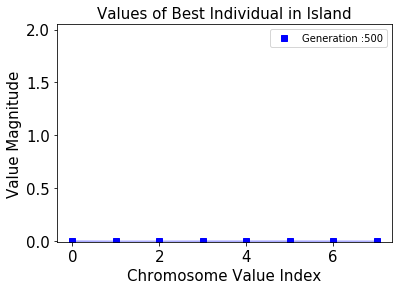

In [17]:
from IPython.display import HTML
# anim = animate_data(best_indv_values)
HTML(animate_data(best_indv_values).to_html5_video())

## Symbolic Regression
## Problem: Given input data, find the functional form of the equation

### Explicit Training Data
The way that acylic graph's fitness is evaluated is whether or not it models some training data correctly. When the output of the input data is known, explicit regression is the appropriate option for the EA algorithm. This requires having some valid `ExplicitTrainingData`

In [51]:
from bingo.SymbolicRegression.ExplicitRegression import ExplicitTrainingData

NUM_POINTS = 100
START = -5
STOP = 5

x = np.linspace(START, STOP, NUM_POINTS).reshape([-1, 1])
y = x**2 + 3.5*x**3
training_data = ExplicitTrainingData(x, y)

### AGraph Component Generator
Acyclic Graphs also require a component generator to generate the nodes that encompass an acylic graph object. The components necessary can be added by creating an instance of the `ComponentGenerator` object and inserting integer-based values for operations. 0 and 1 are default and load the variable and constant data, respectively. 2-12 add operators. See docs for more detail.

In [52]:
from bingo.SymbolicRegression.AGraph.ComponentGenerator import ComponentGenerator

ADD = 2
SUB = 3
MULT = 4

component_generator = ComponentGenerator(x.shape[1])
component_generator.add_operator(ADD)
component_generator.add_operator(SUB)
component_generator.add_operator(MULT)

### AGraph Variation
Set the the variation amongst the population per generation. Mutations will require the component generator in order to create new AGraphs.

In [53]:
from bingo.SymbolicRegression.AGraph.AGraphCrossover import AGraphCrossover
from bingo.SymbolicRegression.AGraph.AGraphMutation import AGraphMutation

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)

### Evaluation: Explicit Regression

The type of regression that will be used is `ExplicitRegression` since the training data has both input and output data to train against.

In [54]:
from bingo.SymbolicRegression.ExplicitRegression import ExplicitRegression

fitness = ExplicitRegression(training_data=training_data)
local_opt_fitness = ContinuousLocalOptimization(fitness, algorithm='lm')
evaluator = Evaluation(local_opt_fitness)

### AGraph Generator
The AGraph generator will use the component generator as before will the mutation class.

In [62]:
from bingo.SymbolicRegression.AGraph.AGraphGenerator import AGraphGenerator

POP_SIZE = 128
STACK_SIZE = 10
ERROR_TOLERANCE = 1e-6

agraph_generator = AGraphGenerator(STACK_SIZE, component_generator)

### Age Fitness Evolutionary Algorithm

The algorithm used is `AgeFitnessEA`. This by default uses the `AgeFitnessSelection`. This also requires use of the `AGraphGenerator` in order to seed a random individual as to address the local minimization problem.

In [56]:
from bingo.Base.AgeFitnessEA import AgeFitnessEA

ea = AgeFitnessEA(evaluator, agraph_generator, crossover,
                      mutation, MUTATION_PROBABILITY,
                      CROSSOVER_PROBABILITY, POP_SIZE)

island = Island(ea, agraph_generator, POP_SIZE)

In [60]:
def animate_data(list_of_best_indv, training_data):

    fig, ax = plt.subplots()
    
    

    num_generations = len(list_of_best_indv)
    x = training_data.x
    y_actually = training_data.y
    y = list_of_best_indv
    plt.plot(training_data.x, training_data.y, 'ro')
    points, = ax.plot(x, y[0].evaluate_equation_at(x), 'b')
    points.set_label('Generation :' + str(0))
    legend = ax.legend(loc='upper right', shadow=True)


    def animate(i):
        ax.collections.clear()
        points.set_ydata(y[i].evaluate_equation_at(x))  # update the data
        points.set_label('Generation :' + str(i))
        legend = ax.legend(loc='upper right')
        return points, legend


    # Init only required for blitting to give a clean slate.
    def init():
        points.set_ydata(np.ma.array(x, mask=True))
        return points, points

    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.title("Best Individual in Island", fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

    return animation.FuncAnimation(fig, animate, num_generations, init_func=init,
                                interval=250, blit=True)

### Simulation
Run until convergence. Print the best result.

In [58]:
i = 1
best_indv_values = []
best_indv_values.append(island.best_individual())
while island.best_individual().fitness > ERROR_TOLERANCE:
    island.execute_generational_step()
    best_indv_values.append(island.best_individual())
    i += 1

print("Generation: ", i)
print("Success!", island.best_individual().get_latex_string())

Generation:  372
Success! (1.7499999997985398)((X_0)((X_0)(X_0) + (X_0)(X_0))) + (X_0)(X_0)


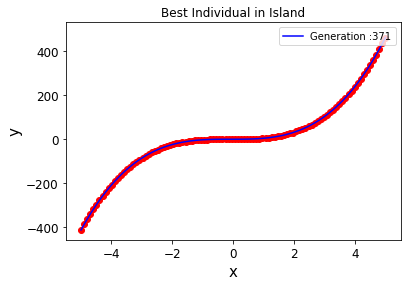

In [61]:
anim2 = animate_data(best_indv_values, training_data)
HTML(anim2.to_html5_video())